In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
proj_path = '/content/drive/MyDrive/Model Development '
os.chdir(proj_path)
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1_QHmZZAWiu1Idc_qP56o_8AWHyZMtSIR/Model Development '

In [ ]:
#Imports
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
!pip install -q pydot
!pip install graphviz
!pip install pydotplus
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#image sizing
IMAGE_SIZE=[224,224,3]
train_path='/content/drive/MyDrive/Model Development /tbdataset/Train'
valid_path='/content/drive/MyDrive/Model Development /tbdataset/Test'

In [ ]:
# Preprocessing the Training set
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Preprocessing the Train set
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Model Development /tbdataset/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
# Preprocessing the Test set
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Model Development /tbdataset/Test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle=False)

Found 3167 images belonging to 2 classes.
Found 791 images belonging to 2 classes.


In [ ]:
IMAGE_SIZE = (224,224,3)

import tensorflow as tf
vgg19 = tf.keras.applications.vgg19.VGG19(
    input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
for layer in vgg19.layers:
    layer._name = layer._name + str('_19')
    layer.trainable = False

effnetb1 =tf.keras.applications.efficientnet.EfficientNetB1(
    include_top=False, weights='imagenet', input_shape=IMAGE_SIZE)
for layer in effnetb1.layers:
    layer._name = layer._name + str('_B1')
    layer.trainable=False

densenet=tf.keras.applications.densenet.DenseNet121(
    include_top=False, weights="imagenet", input_shape=IMAGE_SIZE)
for layer in densenet.layers:
    layer._name = layer._name + str('_Dense')
    layer.trainable=False

In [ ]:
from tensorflow.keras.layers import Input, Flatten, Concatenate, Dense, Average, Dropout
inp = Input(IMAGE_SIZE)
    
vgg19_x = Flatten()(vgg19(inp))

vgg19_x = Dense(256, activation='relu')(vgg19_x)

effnet_x = Flatten()(effnetb1(inp))

effnet_x = Dense(256, activation='relu')(effnet_x)

densenet_x = Flatten()(densenet(inp))

densenet_x = Dense(256, activation='relu')(densenet_x)


In [ ]:
from tensorflow.keras.models import Model

x = Concatenate()([vgg19_x, effnet_x, densenet_x])
x = Dense(128, activation='relu')(x)
x = Dropout(0.30)(x)
x = Dense(128, activation='relu')(x)
out = Dense(2, activation='softmax')(x)

model = Model(inputs = inp, outputs = out)
model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0005,
    name="Adam"),
  metrics=['accuracy']
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, 7, 7, 512)    20024384    input_8[0][0]                    
__________________________________________________________________________________________________
efficientnetb1 (Functional)     (None, 7, 7, 1280)   6575239     input_8[0][0]                    
__________________________________________________________________________________________________
densenet121 (Functional)        (None, 7, 7, 1024)   7037504     input_8[0][0]                    
____________________________________________________________________________________________

In [ ]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=35,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/35
99/99 [==============================] - 267s 3s/step - loss: 1.1854 - accuracy: 0.6950 - val_loss: 0.3551 - val_accuracy: 0.8483
Epoch 2/35
99/99 [==============================] - 232s 2s/step - loss: 0.3854 - accuracy: 0.8364 - val_loss: 0.2927 - val_accuracy: 0.9027
Epoch 3/35
99/99 [==============================] - 232s 2s/step - loss: 0.3190 - accuracy: 0.8573 - val_loss: 0.3092 - val_accuracy: 0.8635
Epoch 4/35
99/99 [==============================] - 234s 2s/step - loss: 0.2812 - accuracy: 0.8759 - val_loss: 0.4883 - val_accuracy: 0.8331
Epoch 5/35
99/99 [==============================] - 241s 2s/step - loss: 0.2575 - accuracy: 0.8904 - val_loss: 0.2414 - val_accuracy: 0.9191
Epoch 6/35
99/99 [==============================] - 240s 2s/step - loss: 0.2572 - accuracy: 0.8990 - val_loss: 0.2861 - val_accuracy: 0.8938
Epoch 7/35
99/99 [==============================] - 243s 2s/step - loss: 0.2388 - accuracy: 0.8986 - val_loss: 0.2927 - val_accuracy: 0.9090
Epoch 8/35
99

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/ensemble/ensemble-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=35,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks = [checkpointer]
)

In [ ]:
test_set.reset()

In [ ]:
predictions = model.predict(test_set, steps = test_set.n // 31, verbose=1)

25/25 [==============================] - 39s 1s/step


In [ ]:
y_classes = predictions.argmax(axis=1)

In [ ]:
y_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

print('Confusion Matrix:')
print(confusion_matrix(test_set.classes, y_classes))

print("Accuracy : " ,accuracy_score(test_set.classes, y_classes))
print("Precision : " ,precision_score(test_set.classes, y_classes))
print("Recall : " ,recall_score(test_set.classes, y_classes))
print("F1 Score : " ,f1_score(test_set.classes, y_classes))

Confusion Matrix:
[[394   3]
 [ 68 326]]
Accuracy :  0.9102402022756005
Precision :  0.9908814589665653
Recall :  0.8274111675126904
F1 Score :  0.9017980636237898


In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(test_set.classes, y_classes)
print("SVM Area under curve -> ",auc(fpr, tpr))

SVM Area under curve ->  0.9099272462248591


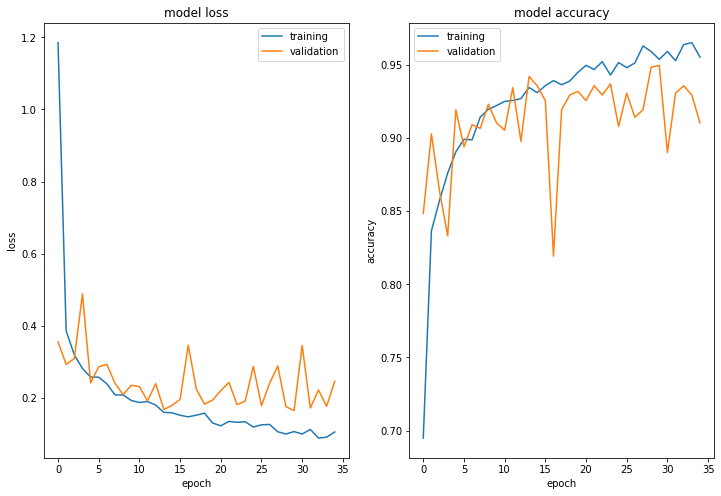

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (12,8))
plt.subplot(1,2,1)
plt.plot(r.history['loss'])
T_loss = r.history['loss']
plt.plot(r.history['val_loss'])
V_loss = r.history['val_loss']
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
  
plt.subplot(1,2,2)
plt.plot(r.history['accuracy'])
T_acc = r.history['accuracy']
plt.plot(r.history['val_accuracy'])
V_acc = r.history['val_accuracy']
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

In [ ]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
99/99 [==============================] - 226s 2s/step - loss: 0.0885 - accuracy: 0.9631 - auc: 0.9948 - precision: 0.9631 - recall: 0.9631 - val_loss: 0.2587 - val_accuracy: 0.9317 - val_auc: 0.9712 - val_precision: 0.9317 - val_recall: 0.9317
Epoch 2/10
99/99 [==============================] - 223s 2s/step - loss: 0.0983 - accuracy: 0.9608 - auc: 0.9940 - precision: 0.9608 - recall: 0.9608 - val_loss: 0.2172 - val_accuracy: 0.9393 - val_auc: 0.9762 - val_precision: 0.9393 - val_recall: 0.9393
Epoch 3/10
99/99 [==============================] - 224s 2s/step - loss: 0.0956 - accuracy: 0.9593 - auc: 0.9941 - precision: 0.9593 - recall: 0.9593 - val_loss: 0.2177 - val_accuracy: 0.9482 - val_auc: 0.9775 - val_precision: 0.9482 - val_recall: 0.9482
Epoch 4/10
99/99 [==============================] - 221s 2s/step - loss: 0.0774 - accuracy: 0.9697 - auc: 0.9962 - precision: 0.9697 - recall: 0.9697 - val_loss: 0.2366 - val_accuracy: 0.9355 - val_auc: 0.9753 - val_precision: 0.9355 -

In [ ]:
test_set.reset()

In [ ]:
predictions = model.predict(test_set, steps = test_set.n // 31, verbose=1)

25/25 [==============================] - 26s 1s/step


In [ ]:
y_classes = predictions.argmax(axis=1)

In [ ]:
y_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

print('Confusion Matrix:')
print(confusion_matrix(test_set.classes, y_classes))

print("Accuracy : " ,accuracy_score(test_set.classes, y_classes))
print("Precision : " ,precision_score(test_set.classes, y_classes))
print("Recall : " ,recall_score(test_set.classes, y_classes))
print("F1 Score : " ,f1_score(test_set.classes, y_classes))

Confusion Matrix:
[[388   9]
 [ 55 339]]
Accuracy :  0.9190897597977244
Precision :  0.9741379310344828
Recall :  0.8604060913705583
F1 Score :  0.9137466307277627


In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(test_set.classes, y_classes)
print("SVM Area under curve -> ",auc(fpr, tpr))

SVM Area under curve ->  0.9188680330908208


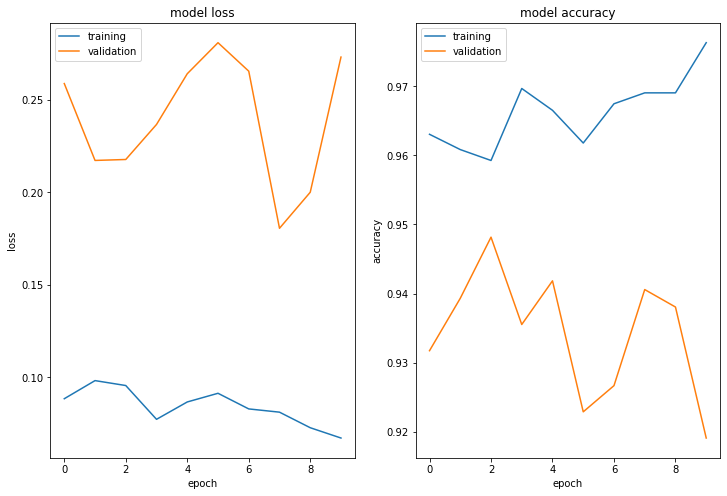

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (12,8))
plt.subplot(1,2,1)
plt.plot(r.history['loss'])
T_loss = r.history['loss']
plt.plot(r.history['val_loss'])
V_loss = r.history['val_loss']
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
  
plt.subplot(1,2,2)
plt.plot(r.history['accuracy'])
T_acc = r.history['accuracy']
plt.plot(r.history['val_accuracy'])
V_acc = r.history['val_accuracy']
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

In [ ]:
vgg_19 = tf.keras.models.load_model('saved_models/vgg19')
vgg_16 = tf.keras.models.load_model('saved_models/vgg16')
dense = tf.keras.models.load_model('saved_models/densenet')
eff = tf.keras.models.load_model('saved_models/efficientnet')

In [ ]:
vgg_pred16 = vgg_16.predict(test_set, steps = test_set.n // 31, verbose=1)
vgg_pred = vgg_19.predict(test_set, steps = test_set.n // 31, verbose=1)
dense_pred = dense.predict(test_set, steps = test_set.n // 31, verbose=1)
eff_pred = eff.predict(test_set, steps = test_set.n // 31, verbose=1)

25/25 [==============================] - 57s 2s/step


In [ ]:
v1_class = vgg_pred16.argmax(axis=1)
v_class = vgg_pred.argmax(axis=1)
d_class = dense_pred.argmax(axis=1)

In [ ]:
#Sort this out!!
e_class = [0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
e_class = np.array(e_class)

In [ ]:
import statistics
maxpred = []

for i in range(0, len(e_class)):
    #calculate the mode and append to maxpred vector
    #maxpred.append(statistics.mode([e_class[i], v_class[i], d_class[i]]))
    ans = 0.25*d_class[i] + 0.25*v_class[i] + 0.3*e_class[i] + 0.2*v1_class[i]
    if ans>=0.5:
      ans = 1
    else:
      ans = 0
    maxpred.append(ans)

In [ ]:
final = np.array(maxpred)

In [ ]:
final = []
for i in range(len(vgg_pred)):
  one = (vgg_pred[i][0] + dense_pred[i][0] + vgg_pred16[i][0] + eff_pred[i][0])/4
  two = (vgg_pred[i][1] + dense_pred[i][1] + vgg_pred16[i][1] + eff_pred[i][0])/4
  l = []
  l.append(one)
  l.append(two)
  final.append(l)

In [ ]:
final = np.array(final)

In [ ]:
final

array([[0.61264074, 0.13735923],
       [0.73817086, 0.01182914],
       [0.65370572, 0.0962943 ],
       ...,
       [0.1021812 , 0.6478188 ],
       [0.54444319, 0.20555682],
       [0.07601932, 0.67398071]])

In [ ]:
final = final.argmax(axis = 1)
final

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Check effnetB1 
Add effnet B0

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

print('Confusion Matrix:')
print(confusion_matrix(test_set.classes, final))

print("Accuracy : " ,accuracy_score(test_set.classes, final))
print("Precision : " ,precision_score(test_set.classes, final))
print("Recall : " ,recall_score(test_set.classes, final))
print("F1 Score : " ,f1_score(test_set.classes, final))

Confusion Matrix:
[[391   6]
 [ 36 358]]
Accuracy :  0.9469026548672567
Precision :  0.9835164835164835
Recall :  0.9086294416243654
F1 Score :  0.9445910290237466


In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(test_set.classes, final)
print("Area under curve -> ",auc(fpr, tpr))

Area under curve ->  0.9467580457492104


In [ ]:
eff_pred

array([[9.4632956e-16, 1.0000000e+00],
       [9.8309661e-16, 1.0000000e+00],
       [1.0164647e-15, 1.0000000e+00],
       ...,
       [9.8742262e-16, 1.0000000e+00],
       [1.0212063e-15, 1.0000000e+00],
       [9.9763011e-16, 1.0000000e+00]], dtype=float32)